# Colourization with Convolutional Neural Networks

This example is adapted from this [notebook](https://github.com/random-forests/applied-dl/blob/master/examples/9-image-colorization.ipynb), which is based on this [article](https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/). We want to solve the problem of colourizing a black and white photo. The idea is to have a network with a number of convolutional layers, that is trained to output the pixel by pixel colour of an image. It is easy to generate training data for this problem, since we can just take image and make training samples by converting them to black and white. 

To make the problem easier we work only with images of the same type of landscape taken on the same day. A few examples of training data can be seen here:

![alt text](https://storage.googleapis.com/machine-learning-course-datasets/bagsvaerdsoe/resized001.png)
![alt text](https://storage.googleapis.com/machine-learning-course-datasets/bagsvaerdsoe/resized008.png)
![alt text](https://storage.googleapis.com/machine-learning-course-datasets/bagsvaerdsoe/resized012.png)
![alt text](https://storage.googleapis.com/machine-learning-course-datasets/bagsvaerdsoe/resized014.png)

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [0]:
import tensorflow as tf
import matplotlib
import numpy as np

from matplotlib import pyplot as plt
from skimage.color import lab2rgb, rgb2lab
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [0]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['axes.grid'] = False

We have 15 training images that we load and convert to a format suitable for the neural network. The images have three channels for each pixel: red, green and blue, but with the function rgb2lab() from scikit-learn we can convert the images into the [CIELAB colour space](https://en.wikipedia.org/wiki/CIELAB_color_space), which also has three channels. In this colour space the first channel is the brightness, the second channel is the green-red scale and the third channel is the blue-yellow scale. 


In the CIELAB colour space the problem of colouring an image becomes the same as predicting channel two and three with channel one as input.

155648/147593 [===============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


139264/137283 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


180224/178450 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


180224/176365 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


180224/176978 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


196608/192426 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


204800/201304 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


196608/189608 [===============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


163840/163394 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


163840/161087 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


163840/158356 [===============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


172032/165431 [===============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


172032/168216 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


163840/159031 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


180224/173807 [===============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


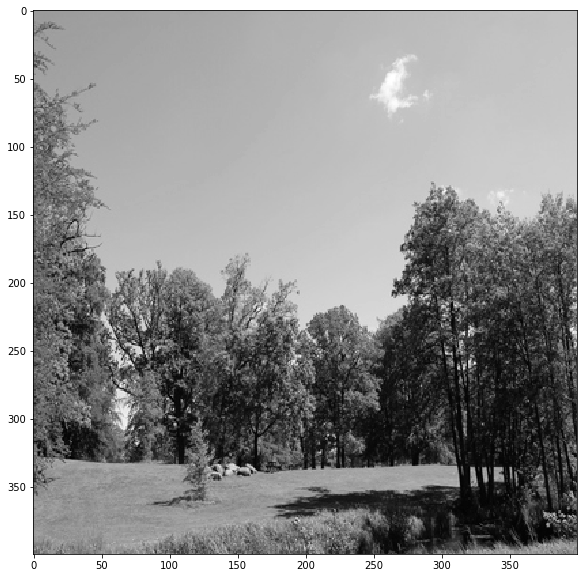

In [6]:
train_size=15
X=np.zeros((train_size, 400, 400, 1))
Y=np.zeros((train_size, 400, 400, 2))
for i in range(train_size):
  filename = "img"+str(i+1)+".jpg"
  url = "https://storage.googleapis.com/machine-learning-course-datasets/bagsvaerdsoe/"+filename
  path = tf.keras.utils.get_file(filename, url)
  img = load_img(path)
  img = img_to_array(img)
  plt.imshow(img)
  img /= 255
  lab = rgb2lab(img)

  X[i,:,:,:]=lab[:,:,0].reshape(400,400,1)
  Y[i,:,:,:]=lab[:,:,1:].reshape(400,400,2)
  
Y /=128
plt.imshow(X[1,:,:,0], cmap="gray")

Our neural network consists of eight convolutional layers. 

In [0]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

This problem is basically a regression problem, so a natural loss-function to use is Mean Squared Error (MSE).

In [0]:
model.compile(optimizer='adam', loss='mse')

In [9]:
model.fit(X, Y, batch_size=1, epochs=100)

Train on 15 samples
Epoch 1/100
15/15 [==============================] - 5s 312ms/sample - loss: 0.6001
Epoch 2/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0616
Epoch 3/100
15/15 [==============================] - 0s 17ms/sample - loss: 0.0279
Epoch 4/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0263
Epoch 5/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0250
Epoch 6/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0236
Epoch 7/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0226
Epoch 8/100
15/15 [==============================] - 0s 17ms/sample - loss: 0.0215
Epoch 9/100
15/15 [==============================] - 0s 17ms/sample - loss: 0.0208
Epoch 10/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0191
Epoch 11/100
15/15 [==============================] - 0s 16ms/sample - loss: 0.0173
Epoch 12/100
15/15 [==============================] - 0s 17ms/sa

Now that we have a trained model, let us first see how it is doing on a image from the training set.

In [0]:

output = model.predict(X)
output *= 128 # scale the output back into Lab

new_image = np.zeros((400, 400, 3))
img_num = 6
new_image[:,:,0] = X[img_num][:,:,0] # copy over the first color channel
new_image[:,:,1:] = output[img_num] # add the two color channels we predicted

rgb = lab2rgb(new_image)

plt.imshow(rgb)

But, of course, we should test our colourization model on an image which is not in the training data, so let us load a black and white image.

In [0]:
X_test=np.zeros((1, 400, 400, 1))
filename = "img16.jpg"
url = "https://storage.googleapis.com/machine-learning-course-datasets/bagsvaerdsoe/"+filename
path = tf.keras.utils.get_file(filename, url)
img = load_img(path)
img = img_to_array(img)
plt.imshow(img)
print(img.shape)
img /= 255
lab = rgb2lab(img)
print(lab.shape)
X_test[0,:,:,:]=lab[:,:,0].reshape(400,400,1)

plt.imshow(X_test[0,:,:,0], cmap="gray")

Colourizing this does not get every pixel right, but even with just 15 training images it does get the general idea.

In [0]:
output = model.predict(X_test)
output *= 128 # scale the output back into Lab

new_image = np.zeros((400, 400, 3))

new_image[:,:,0] = X_test[0,:,:,0] # copy over the first color channel
new_image[:,:,1:] = output[0] # add the two color channels we predicted

rgb = lab2rgb(new_image)

plt.imshow(rgb)